In [1]:
import os, glob
import numpy as np
import xarray as xr
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from glob import glob
import sys
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
sys.path.append('modules')
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import xarray_class_accessors as xca
from importlib import reload
import sn_plotting
import utils
import xarray_extender as xce
import warnings 
import signal_to_noise as sn
warnings.filterwarnings('ignore')
import xarray_extender

from typing import List, Tuple

from classes import LocationsLatLon

# Opening and Processing

In [4]:
reload(constants)

<module 'constants' from '/home/563/ab2313/Documents/PhD/constants.py'>

In [5]:
window = 50

In [6]:
open_kwargs = dict(use_cftime=True, chunks = {'lat': 100, 'lon': 100, 'time': -1})

In [7]:
experiment_ds = xr.open_mfdataset(
    os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, '4xCO2', '*.nc'),  **open_kwargs).compute()
experiment_ds = experiment_ds.isel(time=slice(0,100))

In [8]:
picontrol_ds = xr.open_mfdataset(
    os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'picontrol', '*.nc'), 
                  use_cftime=True, concat_dim='model', combine='nested').compute()

In [9]:
loess_experiment_ds = xr.open_dataset(
    os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'loess', f'1pct_CO2_branch_20.nc'),
    use_cftime=True)

In [10]:
sn.sn_multi_window

<function signal_to_noise.sn_multi_window(experiment_da: xarray.core.dataarray.DataArray, control_da: xarray.core.dataarray.DataArray, windows: Optional[Tuple[int]] = None, start_window=21, end_window=61, step_window=2, parallel=False, lowess_experiment_da: xarray.core.dataarray.DataArray = None, logginglevel='ERROR') -> xarray.core.dataset.Dataset>

In [11]:
# %%time
# unstable_sn_da , stable_sn_da  = sn.sn_multi_window(
#     experiment_ds.tas, picontrol_ds.tas, lowess_experiment_da = loess_experiment_ds.tas, windows=[window])

# unstable_sn_da.to_netcdf(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, f'unstable_sn_{window}.nc'))

# stable_sn_da.to_netcdf(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, f'stable_sn_{window}.nc'))

# unstable_sn_da = xr.open_dataset(
#     os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, f'unstable_sn_{window}.nc')).signal_to_noise
# stable_sn_da = xr.open_dataset(
#     os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, f'stable_sn_{window}.nc')).signal_to_noise

In [12]:
to_concat_stable = []
to_concat_unstable = []
windows = [20, 50]
for window in windows:
    unstable_sn_ds_one_window = xr.open_dataset(
    os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, f'unstable_sn_{window}.nc'))
    
    stable_sn_ds_one_window = xr.open_dataset(
    os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, f'stable_sn_{window}.nc'))
    
    unstable_sn_ds_one_window = unstable_sn_ds_one_window.assign_coords(window=(window))
    stable_sn_ds_one_window = stable_sn_ds_one_window.assign_coords(window=(window))

    
    to_concat_unstable.append(unstable_sn_ds_one_window)
    to_concat_stable.append(stable_sn_ds_one_window)

In [13]:
unstable_sn_da = xr.concat(to_concat_unstable, dim='window')#.signal_to_noise
stable_sn_da = xr.concat(to_concat_stable, dim='window')#.signal_to_noise

In [14]:
unstable_sn_da

<xarray.Dataset>
Dimensions:          (time: 82, model: 8, lat: 96, lon: 192, window: 2)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 0082-12-31 00:00:00
  * model            (model) object 'CESM2' 'CanESM5' ... 'UKESM1-0-LL'
    height           float64 2.0
  * lat              (lat) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * lon              (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * window           (window) int64 20 50
Data variables:
    signal_to_noise  (window, time, model, lat, lon) float64 nan nan ... nan nan

In [15]:
window = unstable_sn_da.window.values

In [16]:
max_effective_length = 200

In [17]:
# first_year_stable_local_ds = unstable_sn_da.reduce(
#     sn.helper_get_stable_arg, axis=unstable_sn_da.get_axis_num('time'),
#                      window=window)

# first_year_stable_local_ds= first_year_stable_local_ds.to_dataset(name='time')

# first_year_stable_local_ds
first_year_stable_local_ds = sn.get_dataset_stable_year_multi_window(
    unstable_sn_da, max_effective_length)
first_year_stable_local_ds

Replacing points greater than 200 with 201


<xarray.Dataset>
Dimensions:   (model: 8, lat: 96, lon: 192, window: 2, variable: 1)
Coordinates:
  * model     (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height    float64 2.0
  * lat       (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * window    (window) int64 20 50
  * variable  (variable) <U15 'signal_to_noise'
Data variables:
    time      (variable, window, model, lat, lon) int64 0 0 0 0 ... 44 44 44 44

In [18]:
# Median year at which they become stable
median_local_stable = xarray_extender.get_median_and_uncertainty_across_dim(first_year_stable_local_ds,
                                                                            dim='model')

median_local_stable

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 192, window: 2, variable: 1)
Coordinates:
    height        float64 2.0
  * lat           (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon           (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * window        (window) int64 20 50
  * variable      (variable) <U15 'signal_to_noise'
Data variables:
    median_value  (variable, window, lat, lon) float64 0.0 0.0 0.0 ... 9.5 9.5
    uncertainty   (variable, window, lat, lon) float64 4.0 4.0 4.0 ... 22.0 22.0

# Plots

In [19]:
notebook_number = 'zec_06'

In [20]:
variable = 'tas'

In [21]:
window_max = median_local_stable.median_value.reduce(np.nanpercentile, dim=['lat', 'lon', 'variable'], q=99
                        ).values

# window_max = [utils.ceil_to_base(window, base) for window, base in zip(window_max, [10, 100, 100])]

plot_dict_median = {window : {'vmax': vmax, 'levels': np.linspace(0, vmax, 11)} for window, vmax in 
             zip(median_local_stable.window.values, window_max)}
plot_dict_median

{20: {'vmax': 6.0,
  'levels': array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ])},
 50: {'vmax': 30.0,
  'levels': array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.])}}

/home/563/ab2313/gdata/images/PhD/top_level/zec_06_tas_median_year_of_stabilisation_and_uncertainty_blues_2.png


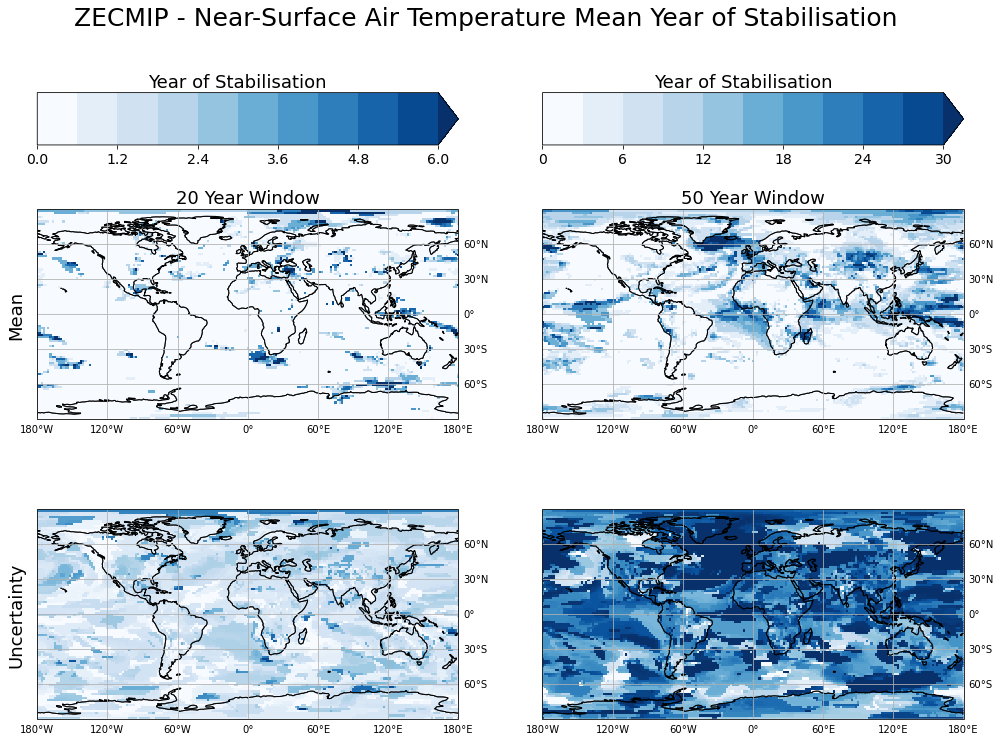

In [22]:
reload(sn_plotting)
fig = sn_plotting.local_stabilisation_average_year_and_uncertainty_plot(
    median_local_stable, plot_dict_median,
    suptitle=f'ZECMIP - {constants.VARIABLE_INFO[variable]["longname"]} Mean Year of Stabilisation',
    cmap='Blues'
)

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_{variable}_median_year_of_stabilisation_and_uncertainty_blues_2.png')
print(save_name)
fig.savefig(save_name, dpi = 200, bbox_inches='tight')

In [30]:
import classes

In [34]:
classes.LocationsLatLon.EPACIFIC.value

(2.7, -85)

Saving /home/563/ab2313/gdata/images/PhD/top_level/zec_06_CESM2_first_40_years.png


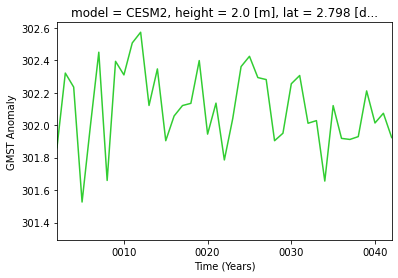

In [40]:
model = 'CESM2'
length = 40


fig = plt.figure()
ax = fig.add_subplot(111)
experiment_ds.sel(model=model).sel(
                  lat=classes.LocationsLatLon.EPACIFIC.value[0], lon=classes.LocationsLatLon.EPACIFIC.value[1],
                  method='nearest'
                 ).tas.plot(ax=ax, c='limegreen')
time = experiment_ds.time.values
ax.set_xlim(time[0],time[length])
ax.set_xlabel('Time (Years)')
ax.set_ylabel('GMST Anomaly')

save_name = f'{constants.IMAGE_SAVE_DIR_TOP_LEVEL}/{notebook_number}_{model}_first_{length}_years.png'
print(f'Saving {save_name}')
# fig.savefig(save_name, dpi=400, bbox_inches='tight')

In [23]:
dims = list(first_year_stable_local_ds.dims)
dims = [d for d in dims if d != 'window']
window_max = first_year_stable_local_ds.reduce(np.nanpercentile,q=99, dim=dims).time.values
window_min = [0, 0, 0]

plot_dict = {window : {'vmax': vmax, 'levels': np.linspace(vmin, vmax, 11)} for window, vmin, vmax in 
             zip(first_year_stable_local_ds.window.values, window_min, window_max)}
plot_dict[50]['levels'] = plot_dict[20]['levels'] * 2#utils.ceil_to_base(plot_dict[50]['levels'], 10)
plot_dict

{20: {'vmax': 30.0,
  'levels': array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.])},
 50: {'vmax': 52.0,
  'levels': array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.])}}

{20: {'vmax': 30.0, 'levels': array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.])}, 50: {'vmax': 52.0, 'levels': array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.])}}
/home/563/ab2313/gdata/images/PhD/top_level/zec_06_tas_all_model_year_of_stabilisation.png


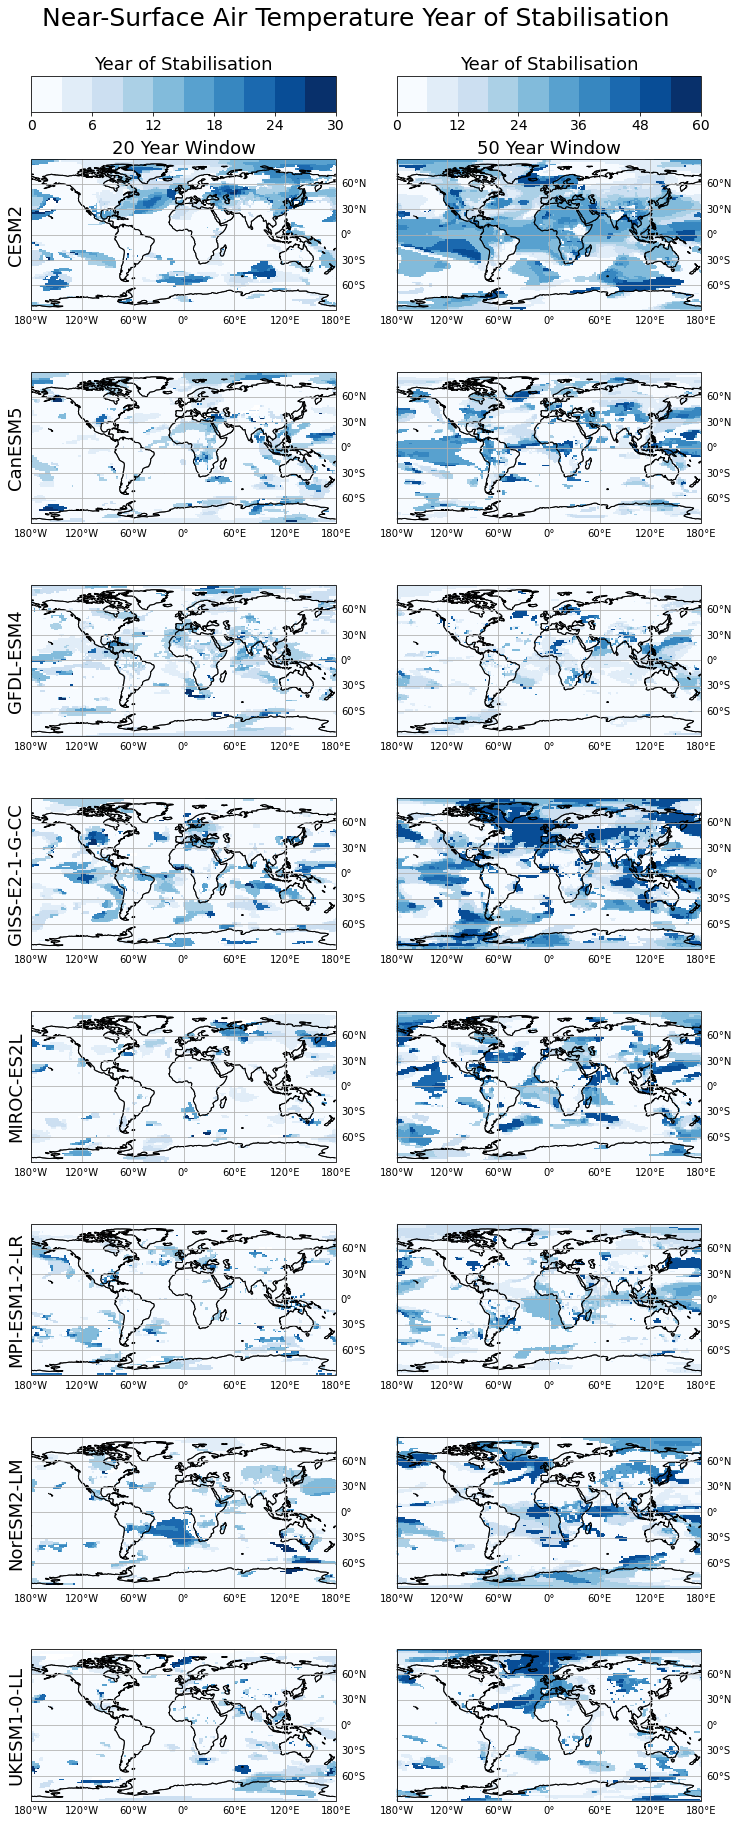

In [26]:
reload(sn_plotting)
fig, axes, plots = sn_plotting.plot_all_model_multi_window_maps(first_year_stable_local_ds, 
                                                                variable, plot_dict
                                                               , extend='neither', cmap='Blues')

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_{variable}_all_model_year_of_stabilisation.png')
print(save_name)
fig.savefig(save_name, dpi = 200, bbox_inches='tight')